## License 

Copyright 2020 Patrick Hall (jphall@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**DISCLAIMER:** This notebook is not legal compliance advice.

***

#### Global hyperpameters

In [1]:
SEED = 12345 # global random seed for better reproducibility

#### Python imports and inits

In [2]:
from rmltk import explain        # simple module for explaining
import h2o                       # import h2o python bindings to h2o java server
import numpy as np               # array, vector, matrix calculations
import pandas as pd              # DataFrame handling
from scipy.special import expit  # for inverse logit
import shap                      # for visualizing Shapley values
import time                      # for timers

import matplotlib.pyplot as plt      # plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# enables display of images in notebook
from IPython.display import Image
from IPython.display import display

# in-notebook display of matplotlib charts
%matplotlib inline

np.random.seed(SEED)                     # set random seed for better reproducibility

h2o.init(max_mem_size='24G', nthreads=4) # start h2o with plenty of memory and threads
h2o.remove_all()                         # clears h2o memory
h2o.no_progress()                        # turn off h2o progress indicators    

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,27 mins 55 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.3
H2O cluster version age:,10 months and 2 days !!!
H2O cluster name:,H2O_from_python_nh112_vxuw52
H2O cluster total nodes:,1
H2O cluster free memory:,20.84 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


#### Start global timer

In [3]:
big_tic = time.time()

## 1. Download, Explore, and Prepare UCI Credit Card Default Data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input features: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

The steps below import a pre-trained model and explain it for the credit card validation data.

#### Import data and reformat

In [9]:
# import XLS file

a=pd.read_csv('xtrain2.csv')
b=pd.read_csv('ytrain.csv')

c= a.drop(a.columns[0], axis=1)
c.head()


,var15,ind_var5,ind_var8_0,ind_var30,num_var5,num_var8_0,num_var30_0,num_var30,num_var42,saldo_var30,var36,num_meses_var5_ult3,num_var4,num_var35
0,23,0,0,0,0,0,3,0,0,0.00,99,0,0,0
1,34,0,0,1,0,0,6,3,0,300.00,3,1,1,3
2,23,1,0,1,3,0,3,3,3,3.00,99,3,1,3
3,37,1,0,1,3,0,3,3,3,70.62,2,2,3,9
4,39,0,0,1,0,0,6,3,3,135003.00,1,3,1,3


In [10]:
d=pd.concat([c, b.reindex(a.index)], axis=1)

d.head()

,var15,ind_var5,ind_var8_0,ind_var30,num_var5,num_var8_0,num_var30_0,num_var30,num_var42,saldo_var30,var36,num_meses_var5_ult3,num_var4,num_var35,TARGET
0,23,0,0,0,0,0,3,0,0,0.00,99,0,0,0,0.0
1,34,0,0,1,0,0,6,3,0,300.00,3,1,1,3,0.0
2,23,1,0,1,3,0,3,3,3,3.00,99,3,1,3,0.0
3,37,1,0,1,3,0,3,3,3,70.62,2,2,3,9,0.0
4,39,0,0,1,0,0,6,3,3,135003.00,1,3,1,3,0.0


#### Assign modeling roles
Selected features are carried forward from the best model in the previous lecture. Notice again that demographic features are not used as model inputs.

In [11]:
# assign target and inputs for models
y_name = 'TARGET'
x_names = ['var15', 'ind_var5', 'ind_var8_0', 'num_var5', 'num_var8_0', 'num_var30_0', 'var36', 'num_var4', 'num_var35', 'ind_var30', 'num_meses_var5_ult3', 'num_var30', 'num_var42', 'saldo_var30']
print('y_name =', y_name)
print('x_names =', x_names)

y_name = TARGET
x_names = ['var15', 'ind_var5', 'ind_var8_0', 'num_var5', 'num_var8_0', 'num_var30_0', 'var36', 'num_var4', 'num_var35', 'ind_var30', 'num_meses_var5_ult3', 'num_var30', 'num_var42', 'saldo_var30']


#### Split data into training and validation partitions
Explanations will be calculated for the validation data to give a better idea of how explanations will look on future unseen data.

In [12]:
iniv=1
d['ID'] = range(iniv, len(d) +iniv)

In [13]:
split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(d)) < split_ratio
train = d[split]
valid = d[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 53281, columns = 16
Validation data rows = 22739, columns = 16


## 2. Load Pre-trained Monotonic GBM
Load the model known as `mgbm5` from the previous lecture.

In [14]:
# load saved best model from lecture 1 
best_mgbm = h2o.load_model('best_mgbm')

# display model details
best_mgbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  best_mgbm


Model Summary: 

,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,201.0,201.0,19845.0,0.0,7.0,1.308458,1.0,16.0,2.965174




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.03537159655951979
RMSE: 0.18807338078399025
LogLoss: 0.1409191484502069
Mean Per-Class Error: 0.26693541844880087
AUC: 0.8034717252775891
pr_auc: 0.13816502391060317
Gini: 0.6069434505551783

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1506643824148352: 

,,0,1,Error,Rate
0,0,46707.0,4359.0,0.0854,(4359.0/51066.0)
1,1,1168.0,921.0,0.5591,(1168.0/2089.0)
2,Total,47875.0,5280.0,0.104,(5527.0/53155.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.150664,0.249966,30.0
1,max f2,0.056158,0.359345,155.0
2,max f0point5,0.153628,0.199054,27.0
3,max accuracy,0.375357,0.960004,0.0
4,max precision,0.301909,0.197368,8.0
5,max recall,0.001590,1.000000,396.0
6,max specificity,0.375357,0.999060,0.0
7,max absolute_mcc,0.081891,0.237840,103.0
8,max min_per_class_accuracy,0.039333,0.728100,206.0
9,max mean_per_class_accuracy,0.040237,0.733065,203.0



Gains/Lift Table: Avg response rate:  3.93 %, avg score:  3.93 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.056232,0.178659,4.435244,4.435244,0.174306,0.188071,0.174306,0.188071,0.249402,0.249402,343.524373,343.524373
1,,2,0.100179,0.143458,4.367946,4.405721,0.171661,0.161579,0.173146,0.176449,0.191958,0.441360,336.794556,340.572100
2,,3,0.150390,0.061049,2.354800,3.720969,0.092544,0.091281,0.146235,0.148014,0.118238,0.559598,135.480019,272.096898
3,,4,0.200000,0.043986,1.418446,3.149832,0.055745,0.048570,0.123789,0.123347,0.070369,0.629966,41.844626,214.983246
4,,5,0.300009,0.037227,1.124834,2.474791,0.044206,0.041006,0.097260,0.095898,0.112494,0.742461,12.483436,147.479076
5,,6,0.403894,0.031310,0.792570,2.042110,0.031148,0.033467,0.080255,0.079841,0.082336,0.824797,-20.742982,104.211006
6,,7,0.503452,0.018440,0.620263,1.760939,0.024376,0.024248,0.069205,0.068847,0.061752,0.886549,-37.973745,76.093906
7,,8,0.601881,0.015482,0.389070,1.536589,0.015291,0.017584,0.060388,0.060464,0.038296,0.924844,-61.092983,53.658942
8,,9,0.708607,0.010355,0.367796,1.360554,0.014454,0.013302,0.053470,0.053360,0.039253,0.964098,-63.220421,36.055357
9,,10,0.800790,0.006969,0.218102,1.229040,0.008571,0.008045,0.048301,0.048144,0.020105,0.984203,-78.189838,22.903981




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.03605593164746368
RMSE: 0.18988399523778637
LogLoss: 0.14236725691584506
Mean Per-Class Error: 0.2618260401160748
AUC: 0.8107667727700805
pr_auc: 0.14446061222510514
Gini: 0.6215335455401609

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1405336107039675: 

,,0,1,Error,Rate
0,0,19942.0,2004.0,0.0913,(2004.0/21946.0)
1,1,495.0,424.0,0.5386,(495.0/919.0)
2,Total,20437.0,2428.0,0.1093,(2499.0/22865.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.140534,0.253361,36.0
1,max f2,0.070675,0.365173,114.0
2,max f0point5,0.159118,0.201973,25.0
3,max accuracy,0.375357,0.959195,0.0
4,max precision,0.343884,0.236364,5.0
5,max recall,0.001209,1.000000,398.0
6,max specificity,0.375357,0.999134,0.0
7,max absolute_mcc,0.070675,0.240522,114.0
8,max min_per_class_accuracy,0.039325,0.732318,196.0
9,max mean_per_class_accuracy,0.037987,0.738174,202.0



Gains/Lift Table: Avg response rate:  4.02 %, avg score:  4.00 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.060136,0.178659,4.505597,4.505597,0.181091,0.188204,0.181091,0.188204,0.270947,0.270947,350.559699,350.559699
1,,2,0.105270,0.150663,4.146717,4.351728,0.166667,0.161527,0.174907,0.176766,0.187160,0.458107,314.671745,335.172757
2,,3,0.152460,0.064047,2.213632,3.689936,0.088971,0.093427,0.148308,0.150971,0.104461,0.562568,121.363230,268.993618
3,,4,0.202274,0.044792,1.813051,3.227715,0.072871,0.048793,0.129730,0.125807,0.090316,0.652884,81.305118,222.771520
4,,5,0.300415,0.037101,1.053311,2.517370,0.042335,0.040968,0.101179,0.098092,0.103373,0.756257,5.331058,151.736960
5,,6,0.401881,0.031310,0.782872,2.079451,0.031466,0.033479,0.083578,0.081779,0.079434,0.835691,-21.712834,107.945086
6,,7,0.501465,0.018440,0.579120,1.781504,0.023276,0.024287,0.071603,0.070361,0.057671,0.893362,-42.088004,78.150446
7,,8,0.600131,0.015482,0.474226,1.566578,0.019060,0.017584,0.062965,0.061684,0.046790,0.940152,-52.577433,56.657799
8,,9,0.707807,0.010355,0.303172,1.374382,0.012185,0.013274,0.055240,0.054320,0.032644,0.972797,-69.682813,37.438164
9,,10,0.802362,0.006969,0.195636,1.235471,0.007863,0.008008,0.049657,0.048862,0.018498,0.991295,-80.436393,23.547136




Scoring History: 

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-06-26 11:14:45,26.413 sec,0.0,0.194308,0.165714,0.500000,0.000000,1.000000,0.960700,0.196412,0.168566,0.500000,0.000000,1.000000,0.959808
1,,2020-06-26 11:14:45,26.487 sec,1.0,0.193796,0.163153,0.727876,0.105502,2.237228,0.249854,0.195857,0.165766,0.739895,0.118676,2.271353,0.271332
2,,2020-06-26 11:14:45,26.555 sec,2.0,0.193377,0.161166,0.730927,0.105301,2.262439,0.243006,0.195401,0.163603,0.742845,0.118720,2.304765,0.246753
3,,2020-06-26 11:14:45,26.621 sec,3.0,0.193037,0.159586,0.732684,0.105493,2.262439,0.244267,0.195021,0.161845,0.743826,0.118821,2.304765,0.271682
4,,2020-06-26 11:14:45,26.690 sec,4.0,0.192126,0.156074,0.769123,0.124844,4.238754,0.114909,0.194095,0.158240,0.779427,0.136145,4.137564,0.119528
5,,2020-06-26 11:14:45,26.770 sec,5.0,0.191873,0.155013,0.768384,0.124846,4.238754,0.114909,0.193816,0.157066,0.779198,0.136303,4.137564,0.119528
6,,2020-06-26 11:14:45,26.841 sec,6.0,0.191192,0.152708,0.769346,0.125171,4.238754,0.114909,0.193127,0.154710,0.779267,0.136479,4.137564,0.119528
7,,2020-06-26 11:14:45,26.913 sec,7.0,0.191014,0.151978,0.770416,0.125361,4.238754,0.114909,0.192935,0.153914,0.779433,0.136537,4.137564,0.119528
8,,2020-06-26 11:14:46,27.030 sec,8.0,0.190507,0.150383,0.771112,0.128343,4.452513,0.114665,0.192421,0.152287,0.780883,0.134470,4.411647,0.119353
9,,2020-06-26 11:14:46,27.142 sec,9.0,0.190386,0.149999,0.772013,0.128972,4.459248,0.114834,0.192287,0.151873,0.780594,0.139448,4.436738,0.100940



See the whole table with table.as_data_frame()

Variable Importances: 

,variable,relative_importance,scaled_importance,percentage
0,var15,201.888504,1.000000,0.347742
1,num_var35,138.383636,0.685446,0.238358
2,ind_var30,135.428543,0.670809,0.233268
3,num_var4,31.200163,0.154542,0.053741
4,num_meses_var5_ult3,28.398340,0.140663,0.048915
5,num_var30_0,16.575937,0.082104,0.028551
6,ind_var8_0,13.406645,0.066406,0.023092
7,num_var8_0,6.805258,0.033708,0.011722
8,var36,5.837318,0.028914,0.010054
9,num_var5,2.191802,0.010856,0.003775


## 3. Main Drivers of Model Decisions: Global Shapley Feature Importance

#### Calculate Shapley values for the MGBM predictions
In `h2o`, for GBM and random forest models, the `predict_contributions` function is used to calculate Shapley values. Notice the Shapley values are the same size as the input feature matrix, plus one constant column for the Shapley intercept.

In [15]:
# must convert from Pandas to H2OFrame ... and back again ... wasteful
shap_contribs_hf = best_mgbm.predict_contributions(h2o.H2OFrame(valid))
shap_contribs_matrix = shap_contribs_hf.as_data_frame().values
print(shap_contribs_matrix)
print('\nShapley contributions rows = %d, columns = %d' % (shap_contribs_matrix.shape[0], shap_contribs_matrix.shape[1]))

[[ 1.10381655e-01 -7.41094165e-03 -8.67367350e-03 ... -1.67471543e-01
  -7.87267610e-02 -3.72998405e+00]
 [ 9.80584621e-01 -5.23025077e-03 -7.53797311e-03 ... -1.48634672e-01
  -9.18084458e-02 -3.72998405e+00]
 [ 6.65658355e-01  3.78142018e-03  2.86629766e-01 ... -1.86428994e-01
  -9.57907736e-03 -3.72998405e+00]
 ...
 [-1.31324136e+00 -1.69461314e-02 -1.42413946e-02 ... -2.73993105e-01
  -6.90423101e-02 -3.72998405e+00]
 [ 6.94273233e-01 -4.37473785e-03 -6.93322858e-03 ... -1.55067489e-01
  -9.26686004e-02 -3.72998405e+00]
 [ 1.01411808e+00  3.07490304e-03  2.51166057e-02 ...  3.87445837e-01
   1.74950376e-01 -3.72998405e+00]]

Shapley contributions rows = 22739, columns = 12


It's crucial to note that Shapley values are calculated on a per-feature, per-customer basis. They are a *local* explanation technique that is aggregated up to a *global* explanation technique.

#### Plot global Shapley feature importance
Global Shapley feature importance is calculated as the average absolute Shapley value for each input feature. The values in the chart below can be interpreted as the mean absolute contribution a feature makes on a model prediction.

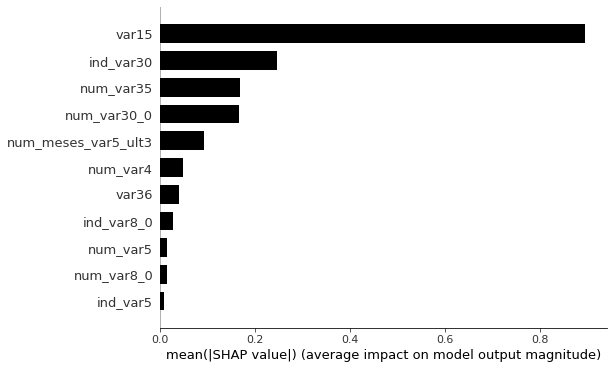

In [16]:
shap_contribs = shap_contribs_matrix[:,:-1] # remove constant intercept column
shap.summary_plot(shap_contribs, x_names, plot_type='bar', color='k') # use shap package for nice bar plot

`PAY_0` dominates the global feature importance, which is actually problematic. This means the model is placing too much importance on one variable, at least on average. What happens if values for this variable drift in the future? What happens if someone learns how to manipulate the predictions of the model based on `PAY_0` values? What if this variable is missing for a customer?

## 4. The Behavior of the Main Drivers: Partial dependence and ICE

Partial dependence and individual conditional expectation (ICE) help paint a more localized portrait of model behavior. Partial dependence can be interpreted as the estimated average output of a model across the values of some interesting input feature. ICE is simply the prediction for an individual of interest when changes are made to a model input feature. Together, these two techniques can describe not only how a model is behaving for some feature of interest, but also, if partial dependence and ICE diverge, whether partial dependence is failing in the presence of strong interactions or correlations. 

#### Calculate partial dependence for each feature in best MGBM

In [17]:
# init dict to hold partial dependence and ICE values
# for each feature
# for mgbm
mgbm_pd_ice_dict = {}

# calculate partial dependence for each selected feature
for xs in x_names: 
    mgbm_pd_ice_dict[xs] = explain.pd_ice(xs, valid, best_mgbm)

#### Find some percentiles of yhat in the validation data
ICE can be plotted for just one or many individuals. Since no particular individual is interesting, yet, under the MGBM, individuals at deciles of `p_DEFAULT_NEXT_MONTH` are selected for ICE.

In [18]:
# merge MGBM predictions onto test data
mgbm_yhat_valid = pd.concat([valid.reset_index(drop=True),
                             best_mgbm.predict(h2o.H2OFrame(valid))['p1'].as_data_frame()],
                            axis=1)

# rename yhat column
mgbm_yhat_valid = mgbm_yhat_valid.rename(columns={'p1':'p_TARGET'})

# find percentiles of predictions
mgbm_percentile_dict = explain.get_percentile_dict('p_TARGET', mgbm_yhat_valid, 'ID')

# display percentiles dictionary
# key=percentile, val=ID
mgbm_percentile_dict

{0: 592,
 99: 670,
 10: 74518,
 20: 21123,
 30: 11142,
 40: 51917,
 50: 44516,
 60: 10166,
 70: 72544,
 80: 38658,
 90: 28083}

#### Calculate ICE curve values

In [22]:
# loop through selected features
for xs in x_names: 

    # collect bins used in partial dependence
    bins = list(mgbm_pd_ice_dict[xs][xs])
    
    # calculate ICE at percentiles 
    # using partial dependence bins
    # for each selected feature
    for i in sorted(mgbm_percentile_dict.keys()):
        col_name = 'Percentile_' + str(i)
        mgbm_pd_ice_dict[xs][col_name] = explain.pd_ice(xs, 
                                                        valid[valid['ID'] == int(mgbm_percentile_dict[i])][x_names], 
                                                        best_mgbm, 
                                                        bins=bins)['partial_dependence']

KeyboardInterrupt: 

#### Assess partial dependence and ICE for each feature in best MGBM
The partial dependence and ICE curves for the monotonic GBM show that it picks up on discrete jumps in the probabilities of default, say at `PAY_* >= 2`. Of all the features, `PAY_0` has the steepest partial dependence and ICE curves, indicating that the model is very sensitive to `PAY_0` values and confirming the findings of the global Shapley feature importance chart above. The partial dependence and ICE curves also confirm the monotonicity of the constrained GBM model on average and for many individuals at tested deciles of `p_DEFAULT_NEXT_MONTH`.

TypeError: Empty 'DataFrame': no numeric data to plot

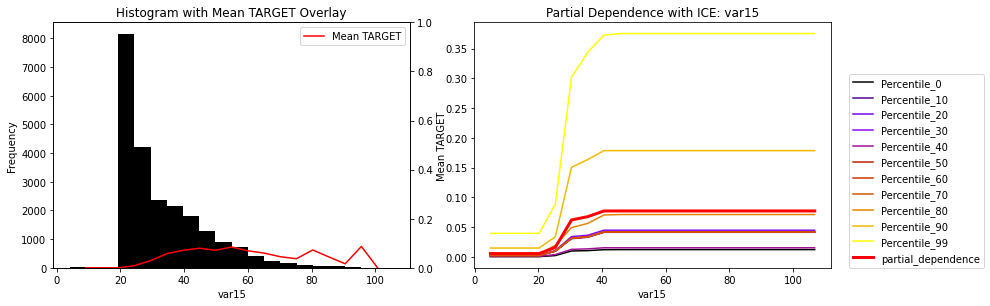

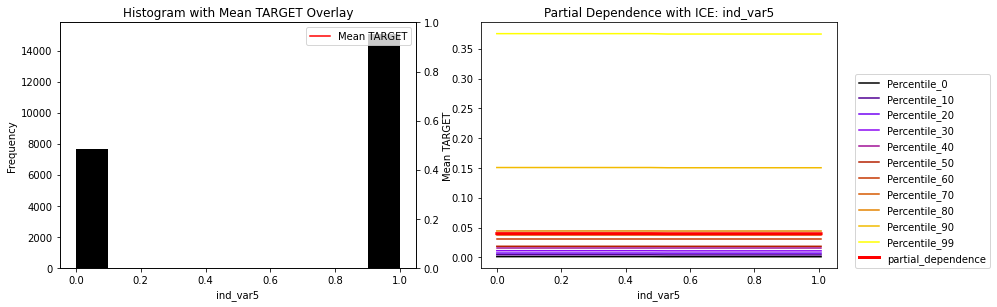

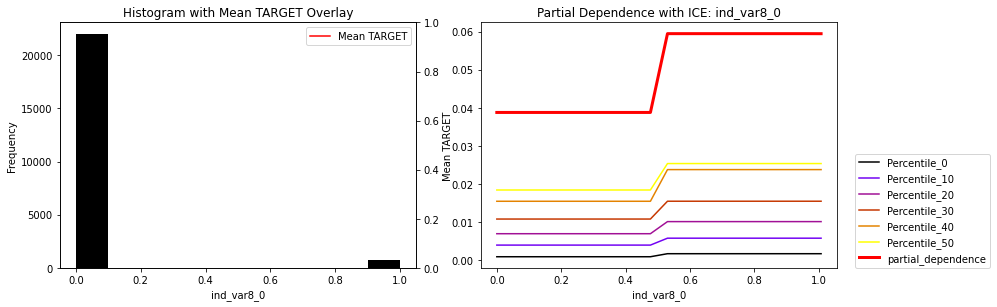

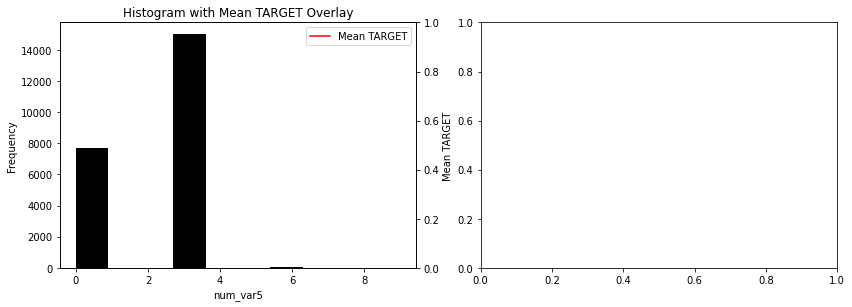

In [23]:
for xs in x_names: 
    explain.hist_mean_pd_ice_plot(xs, y_name, valid, mgbm_pd_ice_dict)

## 5. Main Drivers Interacting: Surrogate Decision Tree 
A surrogate model is a simple model of a complex model. A simple surrogate model can be extracted from a more complex model and used to explain the more complex model, IF the surrogate model is accurate and stable. When a decision tree is used as a surrogate model, it creates a summary flow chart of the more complex model. It can also highlight interacting features. Features in parent-child node relationships in decision trees are likely to have interactions that affect model predictions. If a feature has divergent partial dependence and ICE curves and is in a parent-child node relationship in a surrogate tree model, this is particularly interesting evidence that an interaction is at play. 

#### Train surrogate decision tree 
A simple `depth=4` regression tree is trained with the predictions of the MGBM as the target, and with the original inputs to the GBM as the inputs to the decision tree.

In [14]:
surrogate = explain.get_cv_dt(x_names, 'p_TARGET', mgbm_yhat_valid, 'best_mgbm', SEED, 'Best MGBM Flowchart')

Generated MOJO path:
 /home/patrickh/Workspace/GWU_rml/best_mgbm.zip
Discovered H2O jar path:
 /home/patrickh/Workspace/GWU_rml/env_rml/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /home/patrickh/Workspace/GWU_rml/env_rml/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /home/patrickh/Workspace/GWU_rml/best_mgbm.zip -o best_mgbm.gv --title Best MGBM Flowchart
Calling external process ...
dot -Tpng best_mgbm.gv -o best_mgbm.png


####  Visualize surrogate decision tree

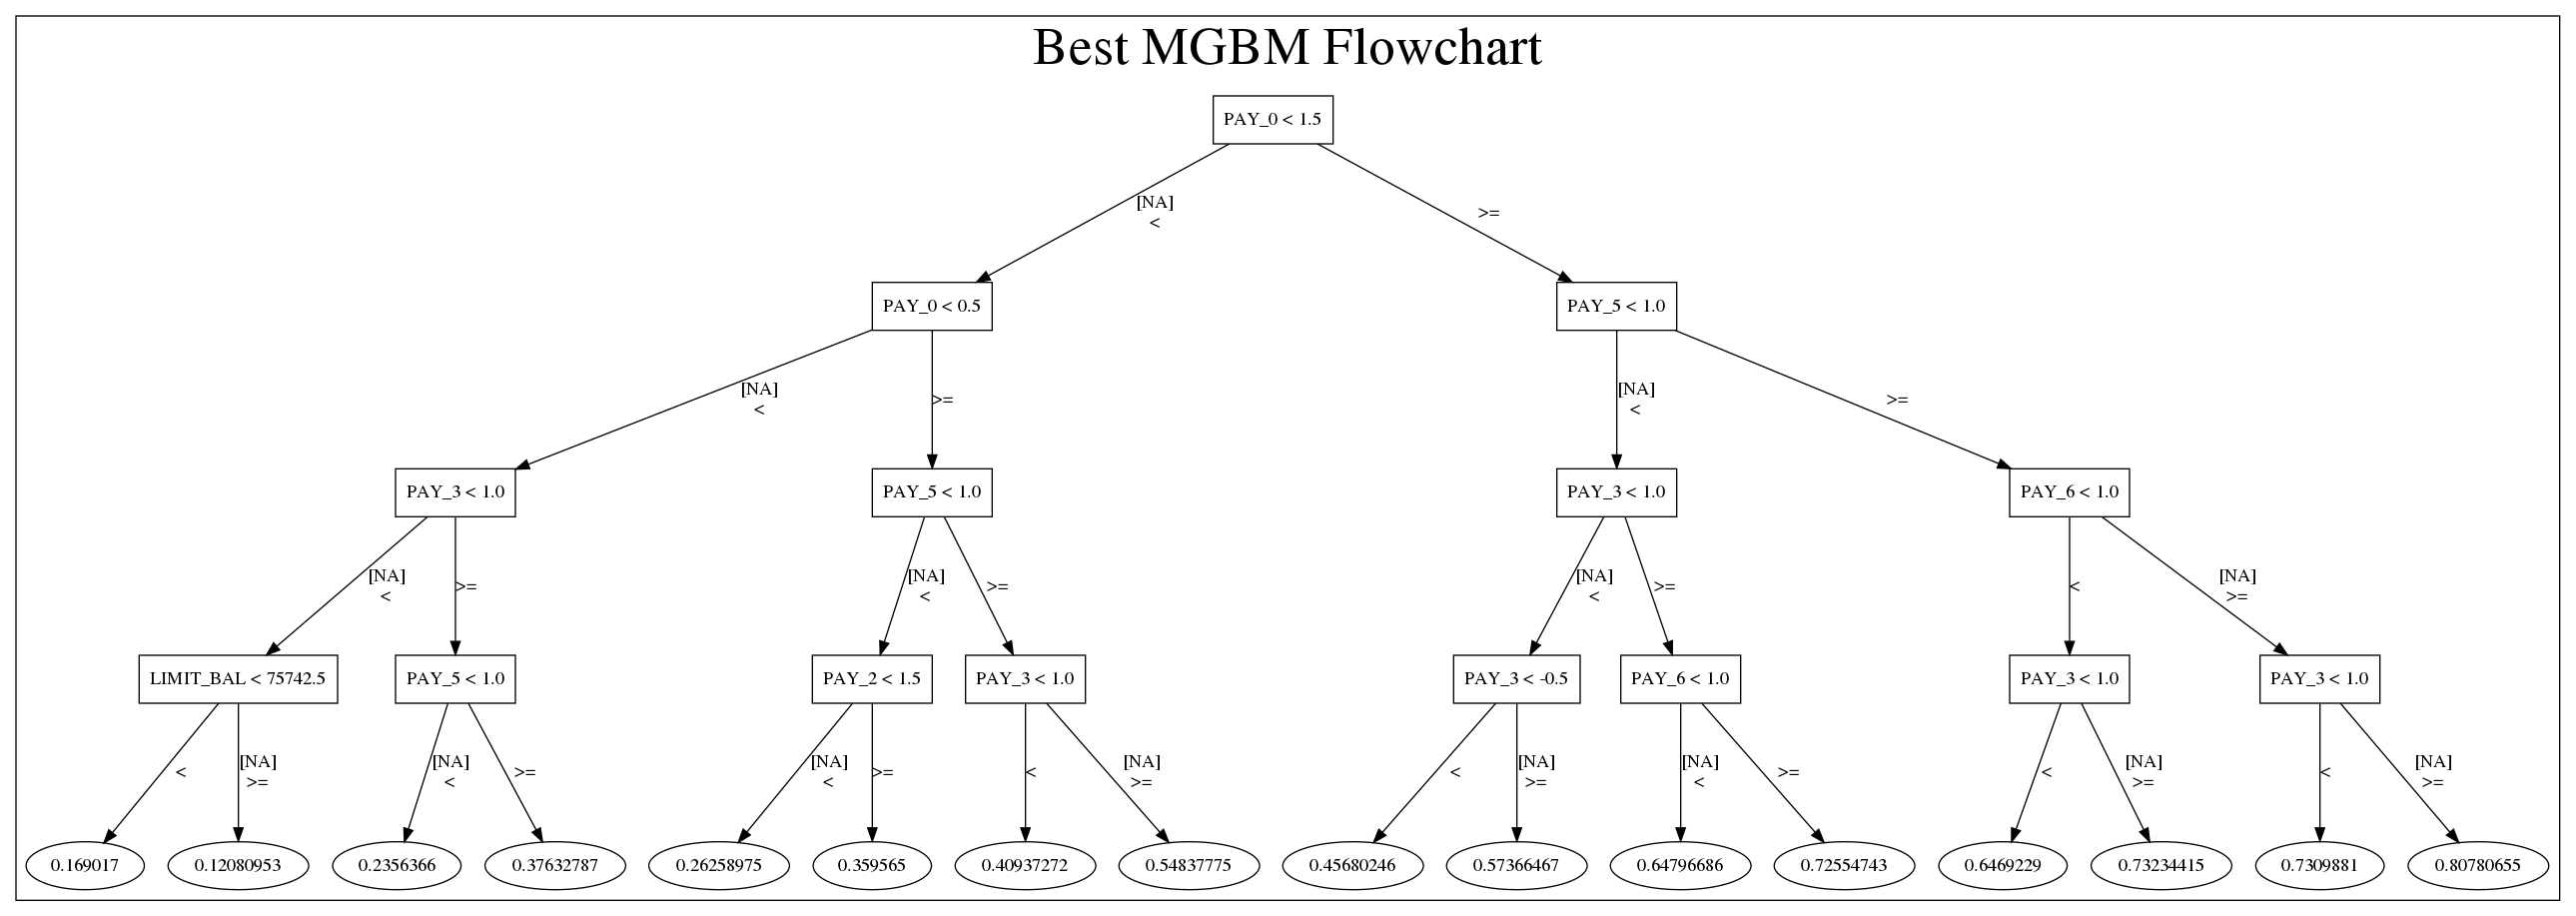

In [15]:
display(Image(('best_mgbm.png')))

The displayed tree serves as a flowchart summary for the `best_mgbm` model. The square nodes represent decision cut points and the circular terminal nodes are estimated predicted probabilities.

#### Assess fit of surrogate decision tree

In [16]:
surrogate.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
0,mae,0.031291604,0.0021172413,0.028846923,0.03253302,0.03249487
1,mean_residual_deviance,0.0017139268,1.2270037E-4,0.0015745525,0.001761558,0.00180567
2,mse,0.0017139268,1.2270037E-4,0.0015745525,0.001761558,0.00180567
3,r2,0.95078444,0.0022910195,0.9532509,0.9503795,0.94872284
4,residual_deviance,0.0017139268,1.2270037E-4,0.0015745525,0.001761558,0.00180567
5,rmse,0.041381575,0.0014960271,0.03968063,0.04197092,0.042493176
6,rmsle,0.033517655,0.0014647902,0.031826653,0.034331735,0.03439458


Because the surrogate decision tree is accurate (`R2 = 0.95`,`RMSE = 0.04`) and stable (small standard deviations for the fit measures), it is **likely** a good summary of `best_mgbm`. Potential interactions between `PAY_0` and `PAY_5` are likely worth investigating. Also, the decision policies in the surrogate tree can be indicative of the decision policies in `best_mgbm`. For instance, the lowest probability of default occurs in the surrogate model when `PAY_0 < 0.5` and `PAY_3 < 1` and `LIMIT_BAL >= 75742.5`. The highest probability of default occurs when `PAY_0 >= 1.5` (as in partial dependence) and `PAY_5 >= 1` and `PAY_6 >= 1` and `PAY_3 >= 1`. When combined with global feature importance and partial dependence/ICE, a fairly clear picture of global model behavior can be presented, especially for constrained models.

## 6. Customer-level Summaries: Local Shapley Explanations
With the exception of ICE, the methods in this notebook have been focused on global summaries of models, or summaries across entire partitions of data. Shapley values and a few other techniques, allow for the construction of highly localized summaries of the customer-level behavior of the model. 

#### Create data structure for local coefficients
Shapley values at the 10th, 50th, and 90th percentiles of `p_DEFAULT_NEXT_MONTH` will be displayed to give some flavor of how `best_mgbm` treats different kinds of customers.

In [17]:
local_coef_dict = {10: pd.DataFrame(columns = ['Shapley Contribution'], index=x_names),
                   50: pd.DataFrame(columns = ['Shapley Contribution'], index=x_names),
                   90: pd.DataFrame(columns = ['Shapley Contribution'], index=x_names)}

#### Create mapping between validation set ID and Shapley value array indices

In [18]:
# validation data IDs are from credit card data
# Shapley contribs are indexed from 0, like any numpy array
valid_idx_map = valid['ID'].copy(deep=True)
valid_idx_map.reset_index(drop=True, inplace=True) # Pandas index will now start from 0
valid_idx_map[0:5] # Shapley array index on left, ID on right

0     1
1     7
2     9
3    11
4    12
Name: ID, dtype: int64

#### Find local contributions for best MGBM at three percentiles of `p_DEFAULT_NEXT_MONTH`
Using the mapping created above, Shapley values for three individuals are extracted from the numpy array of Shapley contributions and stored as DataFrames. 

In [19]:
# loop through features and percentiles
for name in x_names:
    for percentile in [10, 50, 90]:
    
        # use mapping find correct row of Shapley array
        # create a Pandas DataFrame from row of Shapley values
        idx = valid_idx_map[valid_idx_map == int(mgbm_percentile_dict[percentile])].index[0]
        s_df = pd.DataFrame(shap_contribs[idx, :].T, columns=['Shapley Contribution'], index=x_names)
        local_coef_dict[percentile]['Shapley Contribution'] = 0
        local_coef_dict[percentile].update(s_df)

#### Plot Shapley contributions at three percentiles of `p_DEFAULT_NEXT_MONTH`
Shapley values can be interpreted as the contribution that a feature makes to a single prediction, above or below the mean prediction of the model.

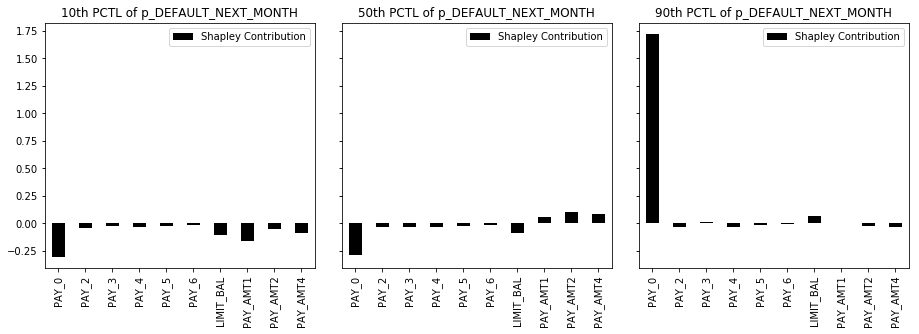

In [20]:
# initialize a three-pane plot
# with shared y-axis
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2, wspace=0.1)

# pane 1
_ = local_coef_dict[10].plot(kind='bar', color='k', ax=ax0,
                             title='10th PCTL of p_DEFAULT_NEXT_MONTH')

#pane 2
_ = local_coef_dict[50].plot(kind='bar', color='k', ax=ax1,
                             title='50th PCTL of p_DEFAULT_NEXT_MONTH')

# pane 3
_ = local_coef_dict[90].plot(kind='bar', color='k', ax=ax2,
                             title='90th PCTL of p_DEFAULT_NEXT_MONTH')

Again, `PAY_0` is exerting the most influence over the model predictions, but this time at the per-customer level. For the lowest probability of default customer, all feature contributions are negative. For the median risk customer, some contributions are positive and some are negative, but `PAY_0` is making the strongest contribution. For the high-risk customer at the 90th percentile of  `p_DEFUALT_NEXT_MONTH`, a large contribution from `PAY_0` seems to be driving them toward predicted default.

#### Data values for individual at 90th percentile of `p_DEFAULT_NEXT_MONTH`

In [21]:
mgbm_yhat_valid[mgbm_yhat_valid['ID'] == mgbm_percentile_dict[90]]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH
2341,7682,60000,2,2,3,64,2,0,0,0,0,0,24541,25838,27022,28357,28992,24505,2000,2000,2000,1000,1000,2000,1,0.553193


#### Shapley values for individual at 90th percentile of `p_DEFAULT_NEXT_MONTH`

In [22]:
local_coef_dict[90]

,Shapley Contribution
PAY_0,1.721030
PAY_2,-0.030681
PAY_3,0.009926
PAY_4,-0.030656
PAY_5,-0.016284
PAY_6,-0.002939
LIMIT_BAL,0.061148
PAY_AMT1,-0.000628
PAY_AMT2,-0.025099
PAY_AMT4,-0.036680


Pairing the data values for the individual with the Shapley values allows it to be seen that:

* Most recent payment status is two months late
* Credit Limit of NT$60000 is low 

are the main causes of high prediction for this individual. These types of explanations are sometimes known as "reason-codes" or "adverse action notices."

#### Shapley values sum to model prediction in logit space
Shapley values plus the Shapley intercept (-1.43555605) will add up to the model prediction for each row before the application of the logit link function. This is one of the most desirable properties of Shapley values.

In [23]:
# should also match PAY_0 ICE plot above ... it does
print('Inverse logit of sum of Shapley contributions and intercept: %.6f' % expit(local_coef_dict[90].sum()[0] + shap_contribs_matrix[0, -1]))
print('MGBM prediction for individual: %6f' % mgbm_yhat_valid[mgbm_yhat_valid['ID'] == mgbm_percentile_dict[90]]['p_TARGET'])

Inverse logit of sum of Shapley contributions and intercept: 0.553193
MGBM prediction for individual: 0.553193


## 7. Customer-level Summaries: Counterfactual or Prototype-based Explanations
Counterfactual and prototype explanations attempt to tell customers what they could change to affect a more positive outcome for the model. Some researchers believe these types of explanations are better suited for human understanding than Shapley values.

#### Select the individual at the 90th percentile of `p_DEFAULT_NEXT_MONTH`

In [24]:
test_row = mgbm_yhat_valid[mgbm_yhat_valid['ID'] == mgbm_percentile_dict[90]].copy(deep=True)

#### Use Shapley values and ICE plots to perturb row
Using Shapley and ICE, the features that are likely to have the greatest effect on an individual's prediction can be seen. For `best_mgbm` and this individual, `PAY_0` is the most important feature. By changing it to a lower value, this individual has a much lower probability of default, likely below the cutoff to receive the credit product.

In [20]:
test_row['var15'] = 0 # create a new prototype customer, based on info from SHAP and ICE
best_mgbm.predict(h2o.H2OFrame(test_row)) 

NameError: name 'test_row' is not defined

**The prototype-based explanation for this individual is:** By changing your most recent payment to on-time, from two months late, you would receive the credit product. 

#### End global timer

In [21]:
big_toc = time.time() - big_tic
print('All tasks completed in %.2f s.' % (big_toc))

All tasks completed in 1357.43 s.


#### Shutdown H2O

In [27]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_b411 closed.
